<a href="https://colab.research.google.com/github/HernanDL/Noise-Cancellation-Using-GenAI/blob/main/ANC_with_CNN_and_Synthetic_Dataset_(test).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
Epoch [1/4], Batch [1/10], Loss: 0.1906
Epoch [1/4], Batch [2/10], Loss: 0.2561
Epoch [1/4], Batch [3/10], Loss: 0.2063
Epoch [1/4], Batch [4/10], Loss: 0.2798
Epoch [1/4], Batch [5/10], Loss: 0.2671
Epoch [1/4], Batch [6/10], Loss: 0.2254
Epoch [1/4], Batch [7/10], Loss: 0.3460
Epoch [1/4], Batch [8/10], Loss: 0.2627
Epoch [1/4], Batch [9/10], Loss: 0.2009
Epoch [1/4], Batch [10/10], Loss: 0.1796
Epoch [1/4] completed. Average Loss: 0.241444
Epoch [2/4], Batch [1/10], Loss: 0.2754
Epoch [2/4], Batch [2/10], Loss: 0.2793
Epoch [2/4], Batch [3/10], Loss: 0.2171
Epoch [2/4], Batch [4/10], Loss: 0.2254
Epoch [2/4], Batch [5/10], Loss: 0.3627
Epoch [2/4], Batch [6/10], Loss: 0.2379
Epoch [2/4], Batch [7/10], Loss: 0.1919
Epoch [2/4], Batch [8/10], Loss: 0.1880
Epoch [2/4], Batch [9/10], Loss: 0.3004
Epoch [2/4], Batch [10/10], Loss: 0.2669
Epoch [2/4] completed. Average Loss: 0.254500
Epoch [3/4], Batch [1/10], Loss: 0.3170
Epoch [3/4], Batch [2/10], Loss: 0.3502
Epoch [3

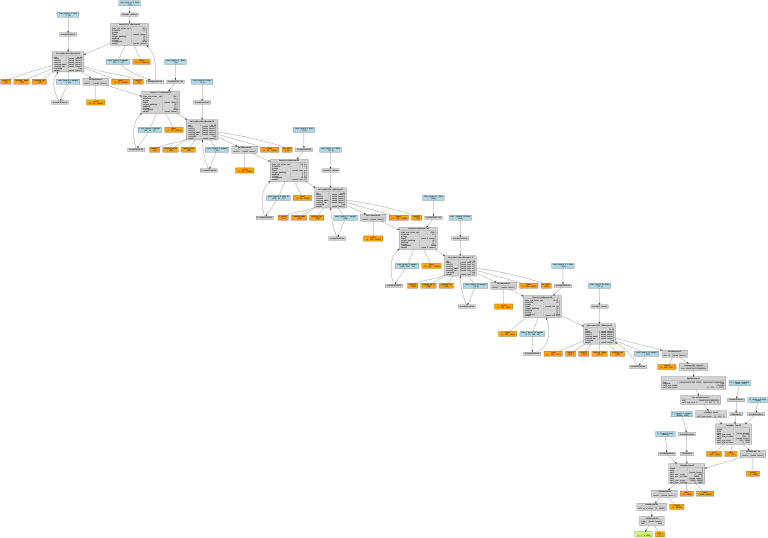

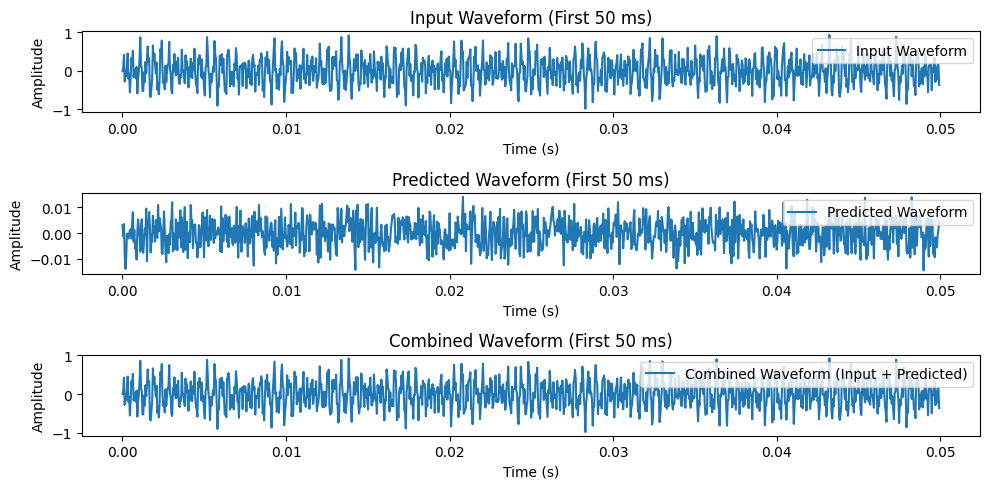

Input Audio:


Predicted Audio:


Combined Audio (Input + Predicted):


In [1]:
# --- INSTALL NECESSARY LIBRARIES ---
!pip install torch torchaudio torchviz matplotlib numpy

# --- IMPORT LIBRARIES ---
import torch
import torch.nn as nn
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchviz import make_dot
from IPython.display import display, Image, Audio

# --- SYNTHETIC DATASET CREATION ---
class SyntheticNoiseDataset(Dataset):
    def __init__(self, num_samples=100, duration=4.0, sr=22050):
        self.num_samples = num_samples
        self.duration = duration
        self.sr = sr

    def generate_random_waveform(self):
        t = np.linspace(0, self.duration, int(self.sr * self.duration))
        num_freqs = np.random.randint(1, 5)  # Randomly choose 1 to 5 frequencies
        waveform = np.sum(
            [np.sin(2 * np.pi * np.random.uniform(20, 20000) * t) for _ in range(num_freqs)], axis=0
        )
        waveform = waveform / np.max(np.abs(waveform))  # Normalize
        return waveform

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        input_waveform = self.generate_random_waveform()
        target_waveform = -input_waveform  # Ideal target for cancellation is the inverse phase
        return torch.tensor(input_waveform, dtype=torch.float32).unsqueeze(0), \
               torch.tensor(target_waveform, dtype=torch.float32).unsqueeze(0)

# --- DATALOADER ---
dataset = SyntheticNoiseDataset(num_samples=100)
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)

# --- CNN MODEL DEFINITION ---
class SimplifiedCNN1D(nn.Module):
    def __init__(self):
        super(SimplifiedCNN1D, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=15, stride=2, padding=7),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=15, stride=2, padding=7),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=15, stride=2, padding=7),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=15, stride=2, padding=7),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 512, kernel_size=15, stride=2, padding=7),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )

        # Global Average Pooling to reduce dimensionality
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # Output is [batch_size, 512, 1]

        # Fully connected layers to generate output waveform
        self.fc_layers = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Linear(4096, 22050 * 4),  # Output matches the flattened input size (for 4 seconds at 22050Hz)
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.conv_layers(x)  # Apply convolutional layers
        x = self.global_pool(x)  # Apply global average pooling
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.fc_layers(x)  # Apply fully connected layers
        x = x.view(x.size(0), 1, -1)  # Reshape back to 1D audio waveform shape
        return x * 0.5  # Scale output to match input amplitude (adjust if necessary)


# --- INITIALIZE MODEL ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimplifiedCNN1D().to(device)
print(f"Using device: {device}")

# --- LOSS AND OPTIMIZER ---
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- TRAIN THE MODEL ---
num_epochs = 4
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i, (input_batch, target_batch) in enumerate(data_loader):
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)

        # Forward pass
        output_batch = model(input_batch)
        loss = criterion(output_batch, target_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Print progress every batch
        print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(data_loader)}], Loss: {loss.item():.4f}')

    print(f'Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {epoch_loss/len(data_loader):.6f}')

print("Training complete!")

# --- VISUALIZE MODEL STRUCTURE ---
dummy_input = torch.randn(1, 1, 22050 * 4).to(device)
model_viz = make_dot(model(dummy_input), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
model_viz.attr(size='8,8')  # Adjust size as needed for compactness
model_viz.render("CNN1D_Model", format="png")
display(Image(filename="CNN1D_Model.png"))

# --- VISUALIZE INPUT, TARGET, AND OUTPUT WAVEFORMS (FIRST 50 MS) ---
model.eval()
with torch.no_grad():
    input_waveform = input_batch[0].cpu().numpy().squeeze()
    target_waveform = target_batch[0].cpu().numpy().squeeze()
    predicted_waveform = output_batch[0].cpu().numpy().squeeze()
    combined_waveform = input_waveform + predicted_waveform

    sr = 22050
    time_axis = np.linspace(0, len(input_waveform) / sr, num=len(input_waveform))
    max_time = 0.05  # 50 ms
    max_samples = int(sr * max_time)
    time_axis_zoomed = time_axis[:max_samples]

    input_waveform_zoomed = input_waveform[:max_samples]
    predicted_waveform_zoomed = predicted_waveform[:max_samples]
    combined_waveform_zoomed = combined_waveform[:max_samples]

    # Plot the waveforms over the first 50 ms
    plt.figure(figsize=(10, 5))
    plt.subplot(3, 1, 1)
    plt.plot(time_axis_zoomed, input_waveform_zoomed, label='Input Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Input Waveform (First 50 ms)')
    plt.legend(loc='upper right')

    plt.subplot(3, 1, 2)
    plt.plot(time_axis_zoomed, predicted_waveform_zoomed, label='Predicted Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Predicted Waveform (First 50 ms)')
    plt.legend(loc='upper right')

    plt.subplot(3, 1, 3)
    plt.plot(time_axis_zoomed, combined_waveform_zoomed, label='Combined Waveform (Input + Predicted)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Combined Waveform (First 50 ms)')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # --- AUDIO PLAYBACK ---
    input_audio = input_waveform / np.max(np.abs(input_waveform))
    predicted_audio = predicted_waveform / np.max(np.abs(predicted_waveform))
    combined_audio = combined_waveform / np.max(np.abs(combined_waveform))

    print("Input Audio:")
    display(Audio(input_audio, rate=sr))

    print("Predicted Audio:")
    display(Audio(predicted_audio, rate=sr))

    print("Combined Audio (Input + Predicted):")
    display(Audio(combined_audio, rate=sr))
